In [158]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from dask.distributed import Client
from pint import UnitStrippedWarning
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint, wrapper
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

warnings.simplefilter("ignore", category=UnitStrippedWarning)

In [159]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/products/Hot_cmems_climato_2002_2014.zarr"
path_to_npp = "../../../1_data_processing/1_1_Forcing/products/Hot_observed_npp_climato.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/products/Hot_obs_zoo_climato_monthly_2002_2015.zarr"
export_file_name = "SeapoPym_HOT_climato_obs_npp_opti_all_parameters_2_groups"

In [160]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-02"
TIME_END = "2009-12-27"
STABILIZATION_TIME = 5
SAVE = False

## Loading


### Forcing


In [161]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 321kB
Dimensions:              (latitude: 1, longitude: 1, depth: 3, time: 1821)
Coordinates:
  * depth                (depth) int64 24B 0 1 2
  * latitude             (latitude) float64 8B 22.75
  * longitude            (longitude) int64 8B -158
  * time                 (time) datetime64[ns] 15kB 2005-01-02 ... 2009-12-27
Data variables: (12/13)
    T                    (latitude, longitude, depth, time) float64 44kB 23.8...
    U                    (latitude, longitude, depth, time) float64 44kB -0.0...
    V                    (latitude, longitude, depth, time) float64 44kB -0.0...
    mnkc_epi             (latitude, longitude, time) float64 15kB 0.2892 ... ...
    mnkc_hmlmeso         (latitude, longitude, time) float64 15kB 0.822 ... 0...
    mnkc_lmeso           (latitude, longitude, time) float64 15kB 2.139 ... 2...
    ...                   ...
    mnkc_mumeso          (latitude, longitude, time) float64 15kB 0.575 ... 0...
    mnkc_umeso           (latitude, longitude, time) float64 15kB 0.5002 ... ...
    npp                  (latitude, longitude, time) float64 15kB 323.3 ... 3...
    pelagic_layer_depth  (latitude, longitude, depth, time) float64 44kB 113....
    zeu                  (latitude, longitude, time) float64 15kB 75.4 ... 75.29
    zooc                 (latitude, longitude, time) float64 15kB 0.2672 ... ...

### Epipelagic layer


In [162]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[113.10354321928514 114.18750083099961 113.81216693411004 ... 113.72807877620157 113.59442872389666 112.94051799923405]]]
Units,meter


<!-- ## Observed NPP -->


In [163]:
observed_npp = xr.open_zarr(path_to_npp)
observed_npp = observed_npp.sel(time=slice(TIME_START, TIME_END))
observed_npp = observed_npp.dropna("time", how="all")
observed_npp = observed_npp.resample(time="D").interpolate("linear")
observed_npp.load()

<xarray.Dataset> Size: 44kB
Dimensions:          (time: 1821, latitude: 1, longitude: 1)
Coordinates:
  * latitude         (latitude) float64 8B 22.75
  * longitude        (longitude) int64 8B -158
  * time             (time) datetime64[ns] 15kB 2005-01-02 ... 2009-12-27
Data variables:
    l12              (time, latitude, longitude) float64 15kB 255.4 ... 257.5
    l12_lowess_0.05  (time, latitude, longitude) float64 15kB 259.5 ... 258.8
Attributes:
    desc:     L12 multiplied by ZEU (from CMEMS).
    type:     climatology

### Observations


In [164]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("depth")
observations

Magnitude,[[[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[179.1993152851171]]] [[[207.78348092804256]]] [[[256.97140808136334]]] [[[276.73713373591653]]] [[[286.8754053335449]]] [[[289.4875232614997]]] [[[315.3292764814672]]] [[[297.1327451472592]]] [[[252.05575513504192]]] [[[201.0579558457]]] [[[167.88955162294909]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]]]
Units,milligram/meter2
Magnitude,[[[[169.028807463174]]] [[[184.16566200957695]]] [[[208.84032451359002]]] [[[249.77746034277746]]] [[[274.8246466780064]]] [[[283.74409762470765]]] [[[288.36278273935625]]] [[[306.0065955062098]]] [[[291.278907182586]]] [[[246.83881007292297]]] [[[204.1907428435882]]] [[[175.24749384551424]]] [[[169.028807463174]]] [[[184.16566200957695]]] [[[208.84032451359002]]] [[[249.77746034277746]]] [[[274.8246466780064]]] [[[283.74409762470765]]] [[[288.36278273935625]]] [[[306.0065955062098]]] [[[291.278907182586]]] [[[246.83881007292297]]] [[[204.1907428435882]]] [[[175.24749384551424]]] [[[169.028807463174]]] [[[184.16566200957695]]] [[[208.84032451359002]]] [[[249.77746034277746]]] [[[274.8246466780064]]] [[[283.74409762470765]]] [[[288.36278273935625]]] [[[306.0065955062098]]] [[[291.278907182586]]] [[[246.83881007292297]]] [[[204.1907428435882]]] [[[175.24749384551424]]] [[[169.028807463174]]] [[[183.22544878939186]]] [[[209.67444462420926]]] [[[249.67832901663408]]] [[[276.32712590507947]]] [[[288.4152516159477]]] [[[290.87610485890576]]] [[[309.7226737506274]]] [[[284.86368409190277]]] [[[250.8354669340342]]] [[[205.83324959699155]]] [[[169.5300410029905]]] [[[169.028807463174]]] [[[184.16566200957695]]] [[[208.84032451359002]]] [[[249.77746034277746]]] [[[274.8246466780064]]] [[[283.74409762470765]]] [[[288.36278273935625]]] [[[306.0065955062098]]] [[[291.278907182586]]] [[[246.83881007292297]]] [[[204.1907428435882]]]]
Units,milligram/meter2
Magnitude,[[[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[310.5038532805829]]] [[[339.1815897155657]]] [[[417.05656045622504]]] [[[416.24639799937876]]] [[[428.83910602723876]]] [[[450.344131523354

Select the kind of observation you want to use.


In [165]:
# observations_selected = observations[["day_lowess_0.2", "night_lowess_0.2"]].rename(
#     {"day_lowess_0.2": "day", "night_lowess_0.2": "night"}
# )

observations_selected = observations[["day", "night"]]

Remove the X first months to let the model reach the stationary state.


In [167]:
observations_selected_without_init = observations_selected.isel(time=slice(STABILIZATION_TIME, None))
observations_selected_without_init

Magnitude,[[[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[179.1993152851171]]] [[[207.78348092804256]]] [[[256.97140808136334]]] [[[276.73713373591653]]] [[[286.8754053335449]]] [[[289.4875232614997]]] [[[315.3292764814672]]] [[[297.1327451472592]]] [[[252.05575513504192]]] [[[201.0579558457]]] [[[167.88955162294909]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]]]
Units,milligram/meter2
Magnitude,[[[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[310.5038532805829]]] [[[339.1815897155657]]] [[[417.05656045622504]]] [[[416.24639799937876]]] [[[428.83910602723876]]] [[[450.3441315233542]]] [[[452.38484638704267]]] [[[411.10336607721837]]] [[[403.9301941931383]]] [[[354.5911867290542]]] [[[285.0364859453825]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]]]
Units,milligram/meter2


Create structure for SeapoPym simulation.


In [98]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=observed_npp["l12"], resolution=1 / 12, timestep=1),
)

2025-01-27 12:37:06,170 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [99]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("D1N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D1N1_tr_max", 0, 50),
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 500),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=1,
        night_layer=0,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("D2N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D2N1_tr_max", 0, 50),
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 0, 500),
    ),
]

In [100]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[Observation(observations_selected_without_init)],
)

Set the genetic algorithm meta parameters.


In [101]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.15,
    INDPB=0.1,
    ETA=5,
    CXPB=0.7,
    NGEN=10,
    POP_SIZE=400,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [102]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [103]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

And watch the magic on the Dask dashboard :


In [104]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58124,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:58135,Total threads: 3
Dashboard: http://127.0.0.1:58139/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:58127,


## Run the optimization


In [105]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,101.823277,349.340117,0.006279,4420.751871,400,0.0000
1,17.321721,93.879272,0.006599,1472.558571,400,0.2500
2,1.040995,8.373861,0.005223,128.426689,400,0.2925
3,3.748861,54.045096,0.003914,1004.424372,400,0.2125
4,6.705240,61.740364,0.004052,840.694429,400,0.2475
5,5.682722,64.505467,0.003270,1192.490123,400,0.2325
6,1.692148,18.118298,0.002732,250.478392,400,0.2750
7,2.346092,22.591617,0.001790,322.924467,400,0.2775
8,0.573167,4.884036,0.001790,89.729003,400,0.2950


Generations: 100%|██████████| 10/10 [03:40<00:00, 22.03s/it]


## Optimization statistics


In [106]:
viewer.hall_of_fame

D1N1_energy_coefficient  D1N1_tr_max  D1N1_tr_rate  \
generation individual                                                       
9          181                        0.225147    49.371398     -0.002120   
7          289                        0.066632    40.719127     -0.002120   
9          285                        0.063573    43.747054     -0.002120   
           312                        0.066632    35.633155     -0.002120   
8          181                        0.063573    40.719127     -0.002120   
...                                        ...          ...           ...   
0          305                        0.142783     1.732501     -0.234776   
1          379                        0.076557    30.623309     -0.099969   
0          256                        0.301757    20.296591     -0.035586   
           380                        0.320912     7.837440     -0.157213   
           104                        0.388298    43.809789     -0.271432   

                       D1N1_inv_lambda_max  D1N1_inv_lambda_rate  \
generation individual                                              
9          181                   30.078397             -0.103733   
7          289                   37.388441             -0.058743   
9          285                   37.388441             -0.058743   
           312                   37.388441             -0.058743   
8          181                   37.388441             -0.058743   
...                                    ...                   ...   
0          305                  431.711030             -0.071584   
1          379                  100.249502             -0.247050   
0          256                  348.452221             -0.004369   
           380                  480.948530             -0.002392   
           104                  473.272251             -0.008800   

                       D2N1_energy_coefficient  D2N1_tr_max  D2N1_tr_rate  \
generation individual                                                       
9          181                        0.126684    11.483564     -0.255170   
7          289                        0.077565    16.134729     -0.021811   
9          285                        0.108979    12.960325     -0.155418   
           312                        0.077565    16.134729     -0.021811   
8          181                        0.108979    12.960325     -0.155418   
...                                        ...          ...           ...   
0          305                        0.296682     3.107529     -0.286990   
1          379                        0.365002    10.969527     -0.021694   
0          256                        0.300920    36.446098     -0.168374   
           380                        0.083766     1.858613     -0.287312   
           104                        0.047930    24.820116     -0.129879   

                       D2N1_inv_lambda_max  D2N1_inv_lambda_rate      fitness  
generation individual                                                          
9          181                  139.039889             -0.210522     0.001636  
7          289                  315.485227             -0.210522     0.001790  
9          285                  110.366146             -0.177396     0.001901  
           312                  315.485227             -0.210522     0.001910  
8          181                  110.366146             -0.177396     0.001944  
...                                    ...                   ...          ...  
0          305                  396.815685             -0.005131  1392.887119  
1          379                  386.414041             -0.007646  1472.558571  
0          256                   39.311894             -0.244690  1832.351965  
           380                  430.528332             -0.173811  3774.029485  
           104                  267.691690             -0.041053  4420.751871  

[3072 rows x 11 columns]

In [107]:
viewer.fitness_evolution()

In [108]:
viewer.box_plot(3, nbest=1000)

In [109]:
fig = viewer.parallel_coordinates(1000, unselected_opacity=0)
fig

In [110]:
if SAVE:
    fig.write_html(f"Parallel_coordinates_{export_file_name}.html")

# Prepare results for ploting


## Run simulation with original parameters


In [111]:
original_config = [[0, 0, 0.1668, 10.38, -0.11, 150, -0.15]]
print(f"Original configuration: {list(original_config[0])}")

Original configuration: [0, 0, 0.1668, 10.38, -0.11, 150, -0.15]


In [112]:
original_model = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=original_config, groups_name=["Total"]),
)

original_model.run()

## Run simulation with optimized parameters


In [113]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {list(best_individual[0])}")
print(f"Best individual: {list(best_individual[1])}")

Best individual: [0.0, 0.0, 0.22514693414708242, 49.37139829430694, -0.0021200642213593524, 30.078397438211056, -0.10373346569639583]
Best individual: [1.0, 0.0, 0.12668391742049367, 11.483564259471969, -0.2551701769262804, 139.03988855808623, -0.210521815090704]


In [114]:
best_model = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=best_individual, groups_name=["D1N1", "D2N1"]),
)

best_model.run()

And with the X best individuals :


In [115]:
NB_INDIVIDUAL_TO_SHOW = 50

min_biomass_D1N1 = best_model.export_biomass().sel(functional_group=0).data.flatten()
max_biomass_D1N1 = best_model.export_biomass().sel(functional_group=0).data.flatten()
min_biomass_D2N1 = best_model.export_biomass().sel(functional_group=1).data.flatten()
max_biomass_D2N1 = best_model.export_biomass().sel(functional_group=1).data.flatten()

for cpt in range(1, NB_INDIVIDUAL_TO_SHOW):
    individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[cpt])
    model = wrapper.model_generator_no_transport(
        forcing_parameters=forcing_parameters,
        fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=individual, groups_name=["D1N1", "D2N1"]),
    )
    model.run()
    min_biomass_D1N1 = np.min([model.export_biomass().sel(functional_group=0).data.flatten(), min_biomass_D1N1], axis=0)
    max_biomass_D1N1 = np.max([model.export_biomass().sel(functional_group=0).data.flatten(), max_biomass_D1N1], axis=0)
    min_biomass_D2N1 = np.min([model.export_biomass().sel(functional_group=1).data.flatten(), min_biomass_D2N1], axis=0)
    max_biomass_D2N1 = np.max([model.export_biomass().sel(functional_group=1).data.flatten(), max_biomass_D2N1], axis=0)

min_biomass_D1N1 = min_biomass_D1N1 * pint.application_registry(model.export_biomass().attrs["units"])
max_biomass_D1N1 = max_biomass_D1N1 * pint.application_registry(model.export_biomass().attrs["units"])
min_biomass_D2N1 = min_biomass_D2N1 * pint.application_registry(model.export_biomass().attrs["units"])
max_biomass_D2N1 = max_biomass_D2N1 * pint.application_registry(model.export_biomass().attrs["units"])

### Format the results


Convert to pandas series.


In [116]:
optimized_biomass_pandas = (
    best_model.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
original_biomass_pandas = (
    original_model.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
observations_day_pandas = (
    observations_selected_without_init.pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .day.dropna("time")
    .to_dataframe()
    .reset_index()
    .set_index("time")["day"]
)
observations_night_pandas = (
    observations_selected_without_init.pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .night.dropna("time")
    .to_dataframe()
    .reset_index()
    .set_index("time")["night"]
)
layer_pandas = epi_layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

Then resample to month.


In [117]:
monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred_d1n1 = optimized_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d1n1.index = monthly_pred_d1n1.index.to_period("M").to_timestamp()

monthly_pred_d2n1 = optimized_biomass_pandas.iloc[:, 1].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d2n1.index = monthly_pred_d2n1.index.to_period("M").to_timestamp()

monthly_pred_orignal = original_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_orignal.index = monthly_pred_orignal.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

# Plot


### Correlation matrix of X best individuals


In [118]:
NB_INDIVIDUAL_CORRELATION = 100

indiv_param = viewer.hall_of_fame.iloc[:NB_INDIVIDUAL_CORRELATION, :-1].to_numpy()
param_names = viewer.hall_of_fame.columns[:-1]

corr_matrix = np.corrcoef(indiv_param.T)
np.fill_diagonal(corr_matrix, np.nan)

fig = px.imshow(
    corr_matrix,
    text_auto=False,
    aspect="auto",
    color_continuous_scale=[[0, "blue"], [0.5, "white"], [1, "red"]],
    zmin=-1,
    zmax=1,
    x=param_names,
    y=param_names,
)
fig.update_layout(
    title="Correlation Matrix of Hall of Fame Parameters (Lower Triangle)",
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    xaxis={"showgrid": False, "tickangle": -35},
    yaxis={"showgrid": False},
)

fig.show()

In [119]:
if SAVE:
    fig.write_html(f"Correlation_best_individuals_{export_file_name}.html")

### Daily with best individuals


In [129]:
x = best_model.export_biomass().time.to_series()
x_rev = pd.concat([x, x[::-1]])

# D1N1 data
y_D1N1 = (
    best_model.export_biomass()
    .sel(functional_group=0)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    .data.flatten()
)
y_D1N1_upper = max_biomass_D1N1.to("milligram / meter ** 2")
y_D1N1_lower = min_biomass_D1N1.to("milligram / meter ** 2")[::-1]
y_D1N1_rev = np.concatenate([y_D1N1_upper, y_D1N1_lower])

# D2N1 data
y_D2N1 = (
    best_model.export_biomass()
    .sel(functional_group=1)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    .data.flatten()
) + y_D1N1
y_D2N1_upper = max_biomass_D2N1.to("milligram / meter ** 2") + y_D1N1_upper
y_D2N1_lower = min_biomass_D2N1.to("milligram / meter ** 2")[::-1] + y_D1N1_lower
y_D2N1_rev = np.concatenate([y_D2N1_upper, y_D2N1_lower])

fig = go.Figure()

# D1N1 traces
fig.add_trace(
    go.Scatter(
        x=x_rev,
        y=y_D1N1_rev,
        fill="toself",
        fillcolor="rgba(255,0,0,0.2)",
        line_color="rgba(255,255,255,0)",
        name=f"D1N1 : {NB_INDIVIDUAL_TO_SHOW} best individuals",
    )
)

fig.add_trace(
    go.Scatter(
        x=x,
        y=y_D1N1,
        line_color="rgb(255,0,0)",
        name="D1N1 : Best individual",
    )
)

# D2N1 traces
fig.add_trace(
    go.Scatter(
        x=x_rev,
        y=y_D2N1_rev,
        fill="toself",
        fillcolor="rgba(0,176,246,0.2)",
        line_color="rgba(255,255,255,0)",
        name=f"D2N1 : {NB_INDIVIDUAL_TO_SHOW} best individuals",
    )
)

fig.add_trace(
    go.Scatter(
        x=x,
        y=y_D2N1,
        line_color="rgb(0,176,246)",
        name="D2N1 : Best individual",
    )
)

# OBSERVATIONS ------------------------------------------------ #

fig.add_trace(
    go.Scatter(
        x=observations_selected_without_init.day.time.data.flatten(),
        y=observations_selected_without_init.day.pint.quantify().pint.to("mg/m2").pint.dequantify().data.flatten(),
        mode="lines+markers",
        name="Day observations",
        line={"dash": "dash", "color": "firebrick", "width": 1},
    )
)

fig.add_trace(
    go.Scatter(
        x=observations_selected_without_init.night.time.data.flatten(),
        y=observations_selected_without_init.night.pint.quantify().pint.to("mg/m2").pint.dequantify().data.flatten(),
        mode="lines+markers",
        name="Night observations",
        line={"dash": "dash", "color": "royalblue", "width": 1},
    )
)

# PRIMARY PRODUCTION ----------------------------------------- #

fig.add_trace(
    go.Scatter(
        x=best_model.state.primary_production.time.data.flatten(),
        y=best_model.state.primary_production.pint.quantify().pint.to("mg/m2/day").pint.dequantify().data.flatten(),
        mode="lines",
        name="Primary Production (mg/m2/day)",
        line={"dash": "dot", "color": "green", "width": 1},
    )
)

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Biomass (mg/m2)",
    title=f"Biomass over Time (Daily) : {export_file_name}",
    showlegend=True,
)

fig.show()

In [130]:
if SAVE:
    fig.write_html(f"Biomass_best_individuals_{export_file_name}.html")

### Monthly with original parameters


In [122]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass during day (CAFE npp) and Observations : HOT station + all param. optimization + 2 groups",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)

# DAY ------------------------------------------------ #

fig.add_trace(
    go.Scatter(
        x=monthly_pred_d1n1.index,
        y=monthly_pred_d1n1,
        mode="lines",
        line={"color": "rgb(255,0,0)"},
        name="Predictions Day",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill="tonextx",
        fillcolor="rgba(255,0,0,0.15)",
        mode="lines+markers",
        line={"color": "firebrick", "dash": "dash", "width": 1},
        name="Observations (day)",
    )
)
# Night ------------------------------------------------ #
fig.add_trace(
    go.Scatter(
        x=(monthly_pred_d1n1 + monthly_pred_d2n1).index,
        y=(monthly_pred_d1n1 + monthly_pred_d2n1),
        mode="lines",
        line={"color": "rgb(0,176,246)"},
        name="Predictions Night",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        fill="tonextx",
        fillcolor="rgba(0,176,246,0.15)",
        mode="lines+markers",
        line={"color": "royalblue", "dash": "dash", "width": 1},
        name="Observations (night)",
    )
)

# LMTL ------------------------------------------------ #
fig.add_trace(
    go.Scatter(
        x=monthly_pred_orignal.index,
        y=monthly_pred_orignal,
        mode="lines",
        line={"color": "grey"},
        name="Predictions Original",
    )
)


# LAYER ------------------------------------------------ #

fig.add_trace(px.line(monthly_layer).data[0])

fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dot"},
)
fig.update_layout(
    yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"},
    height=600,
)
fig.update_layout(legend={"y": 1.0, "x": 1.1})
fig.show()

In [123]:
if SAVE:
    fig.write_html(f"Biomass_monthly_with_original_{export_file_name}.html")

### Taylor Diagram


correlation [0.9045882658107666, 0.9302200591659088, 0.763888661196906, 0.7816789165555131]
norm STD [0.7014083763076575, 1.109380698188336, 1.0754119228808217, 0.91852354018691]
bias [0.07829697602912107, -0.07382066554606069, 0.7594023689943888, -1.617708674354114]
NRMSE [0.4722310206413443, 0.40839830570204033, 0.7166036951237301, 0.638517440975121]
name ['HOT Day', 'HOT Night', 'Original Day', 'Original Night']


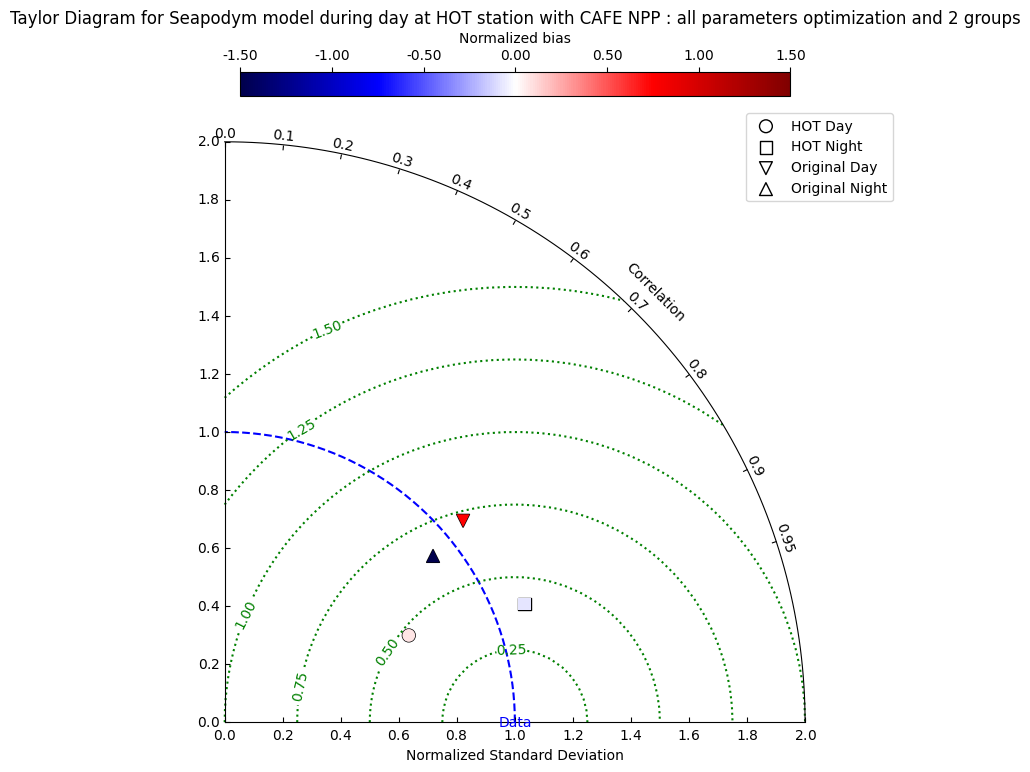

In [131]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred_d1n1, monthly_pred_d1n1 + monthly_pred_d2n1, monthly_pred_orignal, monthly_pred_orignal]
all_obs = [monthly_obs_day, monthly_obs_night, monthly_obs_day, monthly_obs_night]

all_names = ["HOT Day", "HOT Night", "Original Day", "Original Night"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title(
    "Taylor Diagram for Seapodym model during day at HOT station with CAFE NPP : all parameters optimization and 2 groups"
)

# export the figure
if SAVE:
    plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [125]:
if SAVE:
    diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,0.904588,0.701408,0.078297,0.472231
1,HOT Night,0.930220,1.109381,-0.073821,0.408398
2,Original Day,0.763889,1.075412,0.759402,0.716604
3,Original Night,0.781679,0.918524,-1.617709,0.638517
